You are using Google Colab's !unzip command to extract a zip file.

The extracted folder contains your datasets: Books.csv, Ratings.csv, and Users.csv.

After extraction, these files are usually inside a folder named Machine Learning/.

In [7]:
!unzip "/content/Machine Learning-20250914T055612Z-1-001.zip"

Archive:  /content/Machine Learning-20250914T055612Z-1-001.zip
  inflating: Machine Learning/Users.csv  
  inflating: Machine Learning/Ratings.csv  
  inflating: Machine Learning/Books.csv  


**importing all main liabraries**


In [1]:
import os,sys,platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # For Ignore the Warnings
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import estimator_html_repr
import joblib
from IPython.core.display import HTML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils, optimizers, callbacks

**Load all dataset**

In [2]:
file_name1="/content/Machine Learning/Books.csv"
file_name2="/content/Machine Learning/Ratings.csv"
file_name3="/content/Machine Learning/Users.csv"

# Use os.path.join with a base directory like '/content' since the zip extraction created a directory there
file_path1=os.path.join("/content",file_name1)
file_path2=os.path.join("/content",file_name2)
file_path3=os.path.join("/content",file_name3)


if os.path.exists(file_path1) and os.path.exists(file_path2) and os.path.exists(file_path3):
    print("All Files Readed Successfully")
    # Added on_bad_lines='skip' and engine='python' to handle parsing errors
    books=pd.read_csv(file_path1, on_bad_lines='skip', engine='python')
    ratings=pd.read_csv(file_path2, on_bad_lines='skip', engine='python')
    users=pd.read_csv(file_path3, on_bad_lines='skip', engine='python')
else:
    print("File not present in Current Directory")

All Files Readed Successfully


# Data Cleaning


In [3]:
print(books.info())
print("-----------------------------------"*4)
print(books.isnull().sum())
print("-----------------------------------"*4)
print("Duplicated -",books.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None
--------------------------------------------------------------------------------------------------------------------------------------------
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dty

In [4]:
books[books['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


**Filling Nan value**

In [5]:
books.loc[books['ISBN']=='0751352497','Book-Author']='DK'
books.loc[books['ISBN']=='9627982032','Book-Author']="Edinburgh Financial Publishing"

In [6]:
books.loc[books['ISBN']=="078946697X","Image-URL-L"]="https://images.amazon.com/images/P/078946697X.0"
books.loc[books['ISBN']=="2070426769","Image-URL-L"]="https://images.amazon.com/images/P/2070426769.0"
books.loc[books['ISBN']=="0789466953","Image-URL-L"]="https://images.amazon.com/images/P/0789466953.0"

In [7]:
books.loc[books['ISBN']=='193169656X','Publisher']="Novelbooks Inc"
books.loc[books['ISBN']=='1931696993','Publisher']="Novelbooks Inc"

In [8]:
print(ratings.info())
print("-----------------------------------"*4)
print(ratings.isnull().sum())
print("-----------------------------------"*4)
print("Duplicated -",ratings.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None
--------------------------------------------------------------------------------------------------------------------------------------------
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------
Duplicated - 0


In [9]:
print(users.info())
print("-----------------------------------"*4)
print(users.isnull().sum())
print("-----------------------------------"*4)
print("Duplicated -",users.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None
--------------------------------------------------------------------------------------------------------------------------------------------
User-ID          0
Location         0
Age         110762
dtype: int64
--------------------------------------------------------------------------------------------------------------------------------------------
Duplicated - 0


# Merging DataSets

**Merging Books and Rating Dataset**

In [10]:
bookname_with_rating=books.merge(ratings,on="ISBN")
# bookname_with_rating.to_csv("bookname_with-rating.csv")
print("Save CSV File Successfully")

Save CSV File Successfully


In [11]:
bookname_with_rating.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5


In [12]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [13]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# EDA Analysis

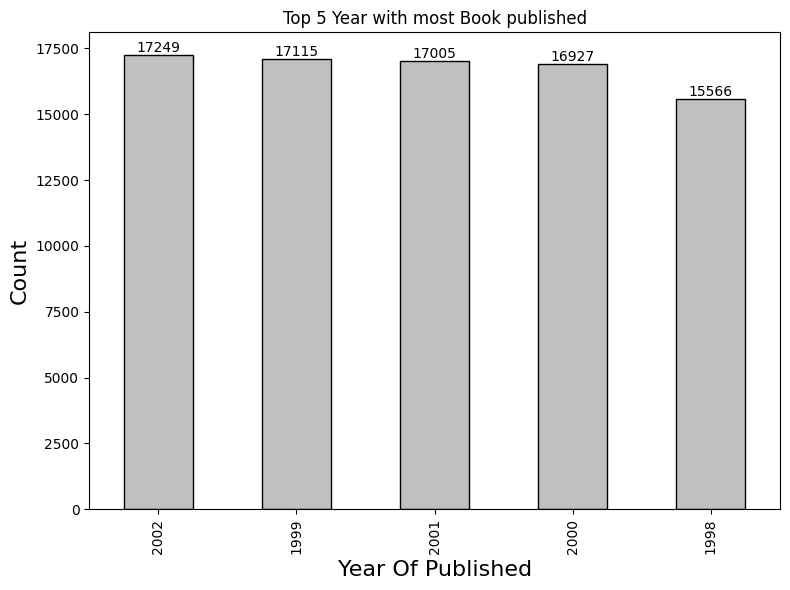

In [14]:
plt.figure(figsize=(8,6))

ax=books.groupby('Year-Of-Publication')['Book-Title'].nunique().sort_values(ascending=False).head(5).plot(kind="bar",edgecolor='black',color='silver')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel("Year Of Published", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Top 5 Year with most Book published")

plt.tight_layout()
plt.show()

>Key Insights

Year 2002 Have most no of book released with quantity of 13624 .



In [15]:
print("After Merging")
print("Total Books are :",bookname_with_rating['Book-Title'].unique().shape[0])
print("Total Book-Authors are :",bookname_with_rating['Book-Author'].unique().shape[0])

After Merging
Total Books are : 241071
Total Book-Authors are : 101589


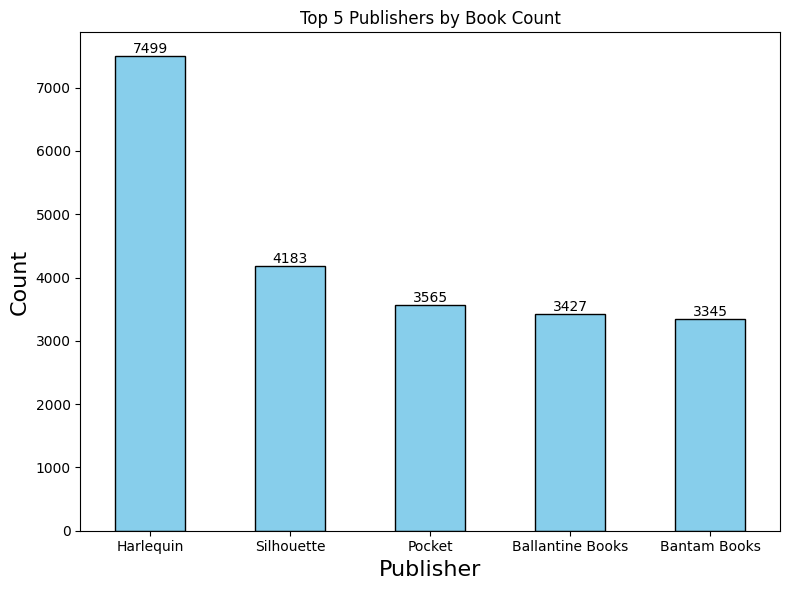

In [16]:
plt.figure(figsize=(8,6))

ax = bookname_with_rating.groupby('Publisher')['Book-Title'].nunique() \
        .sort_values(ascending=False).head(5) \
        .plot(kind="bar", color="skyblue", edgecolor="black")

# Add Values on Bars
for container in ax.containers:
    ax.bar_label(container)

# Add Labels
plt.xticks(rotation=0)
plt.xlabel("Publisher", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Top 5 Publishers by Book Count")

plt.tight_layout()
plt.show()

>Key Insights

Harlequin is the Most book Publisher which is 7499 .

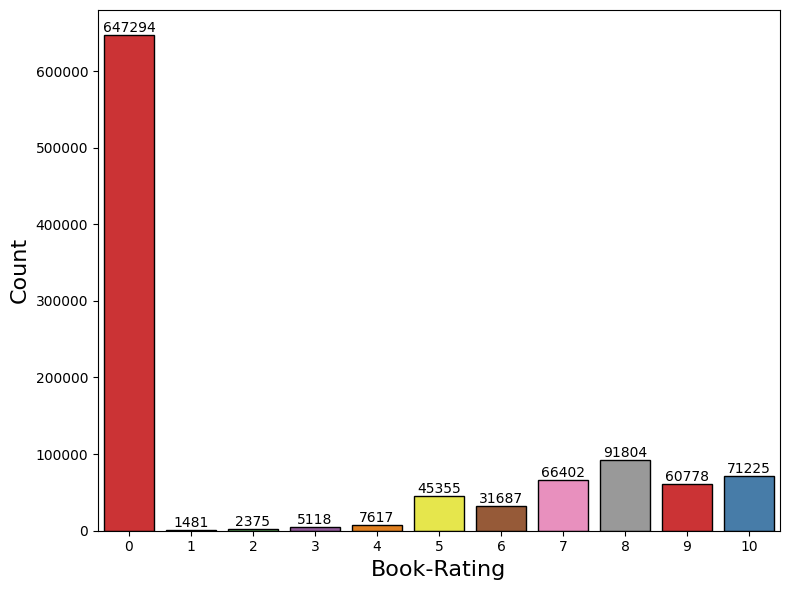

In [17]:
plt.figure(figsize=(8,6))

# Countplot
ax=sns.countplot(data=bookname_with_rating,
              x='Book-Rating',
              palette='Set1',
              edgecolor='black')

# Add Labels to the Bars
for containers in ax.containers:
    ax.bar_label(containers)

# Labels
plt.xlabel("Book-Rating",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.tight_layout()
plt.show()


>Key Insights

More than 50% of Users Vote Zero Rating to Books which is truly unfair bot for all but for most of the books.Therefore ,We take the Expieranced Users who truly reads and comments books

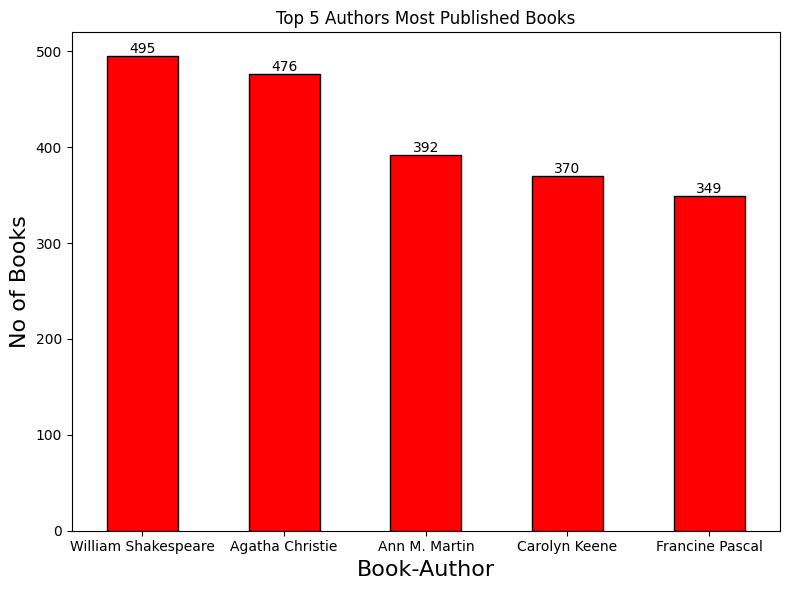

In [18]:
plt.figure(figsize=(8,6))

ax=bookname_with_rating.groupby('Book-Author')['Book-Title'].nunique().sort_values(ascending=False).head(5).plot(kind="bar",color='red',edgecolor='black')


for container in ax.containers:
    ax.bar_label(container)

plt.xticks(rotation=0)
plt.xlabel("Book-Author",fontsize=16)
plt.ylabel("No of Books",fontsize=16)
plt.title("Top 5 Authors Most Published Books")
plt.tight_layout()
plt.show()

>Key Insights

William Shakespeare have make most no. of books in the Dataset .
Agastha Christie also make much Books

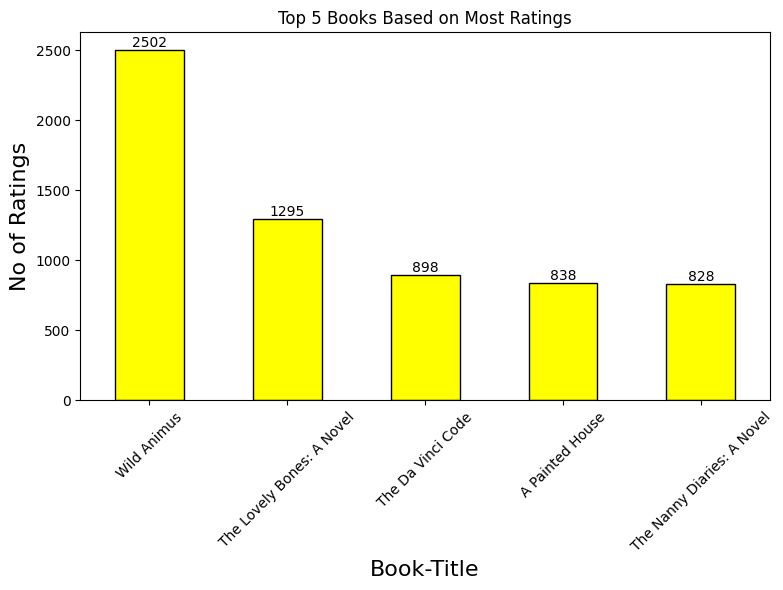

In [19]:
plt.figure(figsize=(8,6))

# Group by based on book title
ax=bookname_with_rating.groupby('Book-Title')['Book-Rating'].count().sort_values(ascending=False).head(5).plot(kind='bar',color='yellow',edgecolor='black')


# Add values on bars
for container in ax.containers:
    ax.bar_label(container)

# Add Labels
plt.xticks(rotation=45)
plt.xlabel('Book-Title',fontsize=16)
plt.ylabel("No of Ratings",fontsize=16)
plt.title("Top 5 Books Based on Most Ratings")

plt.tight_layout()
plt.show()

>Key Insights

Wild Animus is the most rated book in the dataset which is double than Second most popular although which name was The Lovely Bones:A Novel .

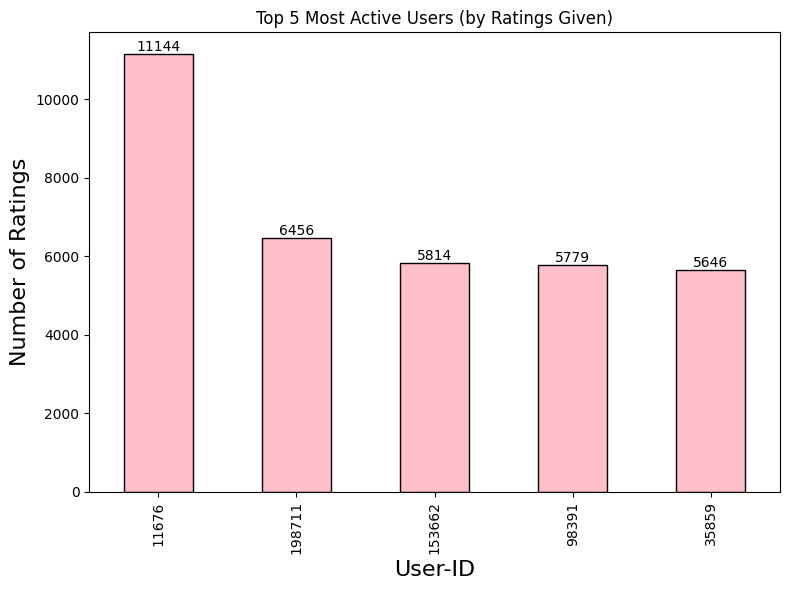

In [20]:
plt.figure(figsize=(8,6))

ax=bookname_with_rating.groupby('User-ID')['Book-Rating'].count().sort_values(ascending=False).head(5).plot(kind='bar',color='pink',edgecolor='black')

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('User-ID',fontsize=16)
plt.ylabel("Number of Ratings", fontsize=16)
plt.title("Top 5 Most Active Users (by Ratings Given)")
plt.tight_layout()
plt.show()

>Key Insights

User with 11676 id Look me the most experienced person with rating of comments on books is 11144 .

# Collaborative based Approach

#### Feature Extraction



>Notes

Created a new column with num of rating per books and Average rating per books



In [21]:
ratings_with_name=bookname_with_rating.copy()

In [22]:
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
num_rating_df


,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241066,Ã?Â?lpiraten.,2
241067,Ã?Â?rger mit Produkt X. Roman.,4
241068,Ã?Â?sterlich leben.,1
241069,Ã?Â?stlich der Berge.,3


In [23]:
ratings_with_name['Book-Rating'] = pd.to_numeric(ratings_with_name['Book-Rating'], errors='coerce')
avg_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
avg_rating_df

,Book-Title,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,2.250000
1,Always Have Popsicles,0.000000
2,Apple Magic (The Collector's series),0.000000
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.000000
4,Beyond IBM: Leadership Marketing and Finance ...,0.000000
...,...,...
241066,Ã?Â?lpiraten.,0.000000
241067,Ã?Â?rger mit Produkt X. Roman.,5.250000
241068,Ã?Â?sterlich leben.,7.000000
241069,Ã?Â?stlich der Berge.,2.666667


In [24]:
popular_df = num_rating_df.merge(avg_rating_df,on='Book-Title')


In [25]:
popular_df.head()

,Book-Title,num_ratings,avg_rating
0,A Light in the Storm: The Civil War Diary of ...,4,2.25
1,Always Have Popsicles,1,0.00
2,Apple Magic (The Collector's series),1,0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.00
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.00


In [26]:
popular_df = popular_df[popular_df['num_ratings']>=250].sort_values('avg_rating',ascending=False).head(50)

In [27]:
popular_df = popular_df.merge(books,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M','num_ratings','avg_rating']]



> Notes
---

*  Filter All user who upload rating greater than 200.
*    Filter All books which has greater than equal 50 rating





In [28]:
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
padhe_likhe_users = x[x].index

In [29]:
filtered_rating = ratings_with_name[ratings_with_name['User-ID'].isin(padhe_likhe_users)]

In [30]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

In [31]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [32]:
final_dataset_colla = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')

In [33]:
final_dataset_colla.fillna(0,inplace=True)

> Notes
---
pt has 706 books(rows) and 810 users(colums).
Now we use cosine similarity for getting relation between each rows(books)






In [34]:
final_dataset_colla.sample(2)

User-ID,254,2276,2766,2977,3363,4017,4385,6251,6323,6543,...,271705,273979,274004,274061,274301,274308,275970,277427,277639,278418
Book-Title,,,,,,,,,,,,,,,,,,,,,
The Sweet Potato Queens' Book of Love,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FORREST GUMP (Movie Tie in),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Cosine similarity score


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
similarity_scores = cosine_similarity(final_dataset_colla)

In [37]:
def recommend(book_name):
    # index fetch
    index = np.where(final_dataset_colla.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]

    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == final_dataset_colla.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))

        data.append(item)

    return data

> Note
---
cosine_similarity → measures similarity between books based on user ratings.
Function recommend() → returns top 4 similar books for a given book.





In [38]:
recommend('1984')

[['Animal Farm',
  'George Orwell',
  'http://images.amazon.com/images/P/0451526341.01.MZZZZZZZ.jpg'],
 ["The Handmaid's Tale",
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0449212602.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['The Vampire Lestat (Vampire Chronicles, Book II)',
  'ANNE RICE',
  'http://images.amazon.com/images/P/0345313860.01.MZZZZZZZ.jpg']]

In [39]:
recommend("WLD ACCORDNG GARP")

[['Degree of Guilt',
  'Richard North Patterson',
  'http://images.amazon.com/images/P/034538184X.01.MZZZZZZZ.jpg'],
 ['Acceptable Risk',
  'Robin Cook',
  'http://images.amazon.com/images/P/0425151867.01.MZZZZZZZ.jpg'],
 ["Fortune's Rocks: A Novel",
  'Anita Shreve',
  'http://images.amazon.com/images/P/0316781010.01.MZZZZZZZ.jpg'],
 ['The Prince of Tides',
  'Pat Conroy',
  'http://images.amazon.com/images/P/0553268880.01.MZZZZZZZ.jpg']]

#### ML algorithm - NearestNeighbors

In [40]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [41]:
nn_model = NearestNeighbors(metric='cosine',algorithm='brute')
nn_model.fit(final_dataset_colla)

NearestNeighbors(algorithm='brute', metric='cosine')

In [42]:
kmeans_model = KMeans(n_clusters=3,init="k-means++",random_state=12)
km = kmeans_model.fit(final_dataset_colla)
km_pred = km.predict(final_dataset_colla)

silhouette_score(final_dataset_colla,km_pred)

-0.02951020137408856

In [43]:
gm_model = GaussianMixture(n_components=3,random_state=12)
gm = gm_model.fit(final_dataset_colla)
gm_pred = km.predict(final_dataset_colla)

silhouette_score(final_dataset_colla,gm_pred)

-0.02951020137408856

In [44]:
def recommend_nn(book_name):
    dist , sugg = nn_model.kneighbors(final_dataset_colla[final_dataset_colla.index == book_name],n_neighbors=6)
    print('Book Recommendation for',book_name,'are:')
    for i in range(len(sugg[0])):
        if i!=0:
            print(i,final_dataset_colla.index[sugg[0][i]])

In [45]:
recommend_nn("River's End")

Book Recommendation for River's End are:
1 Sanctuary
2 Midnight Bayou
3 Heart of the Sea (Irish Trilogy)
4 Jewels of the Sun (Irish Trilogy)
5 Macgregor Brides (Macgregors)


# Content Based Approach

#### feature extraction

In [46]:
final_df=bookname_with_rating.copy()
content_users=users.copy()

In [47]:
num_rating_df = final_df.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)

final_df['Book-Rating'] = pd.to_numeric(final_df['Book-Rating'], errors='coerce')
avg_rating_df = final_df.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_rating_df.rename(columns={'Book-Rating':'avg_rating'},inplace=True)
popular_df = final_df.merge(avg_rating_df,on='Book-Title')

x = final_df.groupby('User-ID').count()['Book-Rating'] > 200
padhe_likhe_users = x[x].index
filtered_rating = final_df[final_df['User-ID'].isin(padhe_likhe_users)]

y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>=50
famous_books = y[y].index

final_df = filtered_rating[filtered_rating['Book-Title'].isin(famous_books)]

In [48]:
final_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'Year-Of-Publication'], axis=1, inplace=True)
content_users.drop(['Location', 'Age'], axis=1, inplace=True)

In [49]:
final_df = pd.merge(final_df, content_users, on='User-ID')

#### Word2Vec Algorithm

In [50]:
!pip install nltk


In [64]:
!pip install gensim

In [51]:
final_df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'User-ID',
       'Book-Rating'],
      dtype='object')

In [52]:
books = final_df[['ISBN', 'Book-Title', 'Book-Author', 'Publisher']].drop_duplicates()
books['content'] = (
    books['Book-Title'].fillna('') + ' ' +
    books['Book-Author'].fillna('') + ' ' +
    books['Publisher'].fillna('')
)

In [53]:
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # keep only letters
    tokens = word_tokenize(text)
    return tokens

books['tokens'] = books['content'].apply(preprocess)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [54]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=books['tokens'], vector_size=100, window=5, min_count=2, workers=4)

In [55]:
def get_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(np.array(vectors), axis=0)

books['vector'] = books['tokens'].apply(lambda x: get_vector(x, model))

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

book_vectors = np.vstack(books['vector'].values)
cosine_sim = cosine_similarity(book_vectors)


In [63]:
indices = pd.Series(books.index, index=books['Book-Title']).drop_duplicates()

def recommend_books(title, k=10):
    if title not in indices:
        return f"'{title}' not found in dataset"

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1].mean(), reverse=True)
    sim_scores = sim_scores[1:k+1]

    book_indices = [i[0] for i in sim_scores]
    return books[['Book-Title', 'Book-Author', 'Publisher']].iloc[book_indices]


In [96]:
recommend_books("The Kitchen God's Wife")

,Book-Title,Book-Author,Publisher
42385,The Face of Deception,Iris Johansen,Bantam Books
52086,Kiss the Girls,James Patterson,Warner Books
36823,Full House (Janet Evanovich's Full Series),Janet Evanovich,St. Martin's Paperbacks
4216,Chicken Soup for the Woman's Soul (Chicken Sou...,Jack Canfield,Health Communications
14112,"The Subtle Knife (His Dark Materials, Book 2)",Philip Pullman,Scholastic Point
